##Overview

# Sensing a Vibe: Annotation and Classification Notebook

This notebook contains all code for:
- Random sampling of artworks for manual annotation
- Calculating Kohen's Cappa and intercoder agreement
- Calculation of hard + soft labels
- Automated classification of artworks using GPT (zero-shot and two-shot)
- Data analysis

as described in the thesis:

"Sensing a Vibe: Exploring Serendipitous Discovery and Engagement for Casual Users via Digital Exploration of Internet Aesthetics for Digital Cultural Heritage Collections" (Rangelova, 2025, University of Amsterdam

**Requirements:** Python 3.x, pandas, openai, numpy, sklearn.metrics
**Data:** Artpedia dataset (download [here](aesthetics.fandom.com/wiki/Category:Internet_Aesthetics)), internet_aesthetics_dataset.csv (included in the repository)


In [3]:
# Requirements: pandas, openai
!pip install pandas openai
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from collections import Counter
import random
from sklearn.metrics import cohen_kappa_score
from collections import Counter
import random

## Load Internet Aesthetics Dataset

The following cell loads the `internet_aesthetics_dataset.csv`, which contains all internet aesthetics categories, URL's to the specific page on Aesthetics Wiki, short descriptions, and metadata.  
This dataset was compiled by scraping the [Aesthetics Wiki](https://aesthetics.fandom.com/wiki/Category:Internet_Aesthetics) and is included in this repository for reproducibility.


In [ ]:
import pandas as pd

ia_df = pd.read_csv('internet_aesthetics_dataset.csv')


1. Random selection for manual annotation - 300 paintings

In [ ]:
#Sample 300 random paintings
sampled_titles = df[['title', 'image_url','year_painted', 'contextual sentence', 'visual sentence']].sample(n=330, random_state=42).reset_index(drop=True)

# Display the result
print(sampled_titles)


                                                 title  \
0                                The Stonemason's Yard   
1                          Man Between Vice and Virtue   
2                                    Living Still Life   
3                                    Las Damas Romanas   
4                            The Fifth Plague of Egypt   
..                                                 ...   
325  Shirley Temple, The Youngest, Most Sacred Mons...   
326                               Passerini Assumption   
327                          The Ironworkers' Noontime   
328                        On the Threshold of Liberty   
329                  Cow's Skull: Red, White, and Blue   

                                             image_url  year_painted  \
0    https://upload.wikimedia.org/wikipedia/commons...          1720   
1    https://upload.wikimedia.org/wikipedia/commons...          1892   
2    https://upload.wikimedia.org/wikipedia/en/7/7e...          1956   
3    https://up

In [ ]:

# Path to your existing CSV file
input_path = #yourpath

# Load the CSV
df = pd.read_csv(input_path)

# Remove the first 30 rows
df_trimmed = df.iloc[30:].reset_index(drop=True)

# Save back to the same file or a new one
output_path =
df_trimmed.to_csv(output_path, index=False)


print(f"Trimmed CSV saved to {output_path}")



Trimmed CSV saved to /content/drive/MyDrive/selected_paintings_trimmed.csv


In [ ]:
df_trimmed.head()

,title,image_url,year_painted,contextual sentence,visual sentence
0,The Death of the Earl of Chatham,https://upload.wikimedia.org/wikipedia/commons...,1781,"['It depicts the collapse of William Pitt, 1st...",['The Death of the Earl of Chatham is the titl...
1,The Procuress (Vermeer),https://upload.wikimedia.org/wikipedia/commons...,1656,['It is his first genre painting and shows a s...,['The Procuress is a 1656 oil-on-canvas painti...
2,The Baptism of the Eunuch,https://upload.wikimedia.org/wikipedia/commons...,1626,['It shows Philip the Evangelist baptising an ...,['The Baptism of the Eunuch is a 1626 painting...
3,"Saint Sebastian (El Greco, 1576–1579)",https://upload.wikimedia.org/wikipedia/commons...,1570,['It shows the Martyred Saint in an atypical k...,"['""The Martyrdom of Saint Sebastian"" redirects..."
4,Portrait of Pope Paul III (Titian),https://upload.wikimedia.org/wikipedia/commons...,1545,"[""Portrait of Pope Paul III (or Portrait of Po...",['It is in the collection of the Capodimonte M...


# Calculating Kohen’s kappa value and prevalence table

In [ ]:
# Paths to your annotation files in Google Drive
file1 = #yourpath
file2 = #yourpath
file3 = #yourpath

# Read Excel files
df1 = pd.read_excel(file1)
df2 = pd.read_excel(file2)
df3 = pd.read_excel(file3)

# Ensure rows are aligned (by Title or image url)
# Merge on 'title' or 'image url' as appropriate
df = df1[['Title', 'Aesthetic']].merge(
    df2[['Title', 'Aesthetic']], on='Title', suffixes=('_1', '_2')
).merge(
    df3[['Title', 'Aesthetic']], on='Title'
)
df = df.rename(columns={'Aesthetic': 'Aesthetic_3'})

# Helper: Split multi-label cells and sort for comparison
def process_labels(cell):
    if pd.isna(cell):
        return []
    return sorted([x.strip() for x in str(cell).split(',') if x.strip()])

# Get all unique labels
all_labels = set()
for col in ['Aesthetic_1', 'Aesthetic_2', 'Aesthetic_3']:
    df[col] = df[col].apply(process_labels)
    for labels in df[col]:
        all_labels.update(labels)

all_labels = sorted(all_labels)

# Create binary indicator columns for each label/coder
for coder in [1, 2, 3]:
    for label in all_labels:
        df[f'{label}_coder{coder}'] = df[f'Aesthetic_{coder}'].apply(lambda x: int(label in x))

# Cohen's Kappa for each coder pair, for each label
print("Cohen's Kappa scores (per label, per coder pair):")
for label in all_labels:
    for (a, b) in [(1, 2), (1, 3), (2, 3)]:
        kappa = cohen_kappa_score(df[f'{label}_coder{a}'], df[f'{label}_coder{b}'])
        print(f"Label: {label} | Coder {a} vs Coder {b}: Kappa = {kappa:.3f}")

# Prevalence table: How often each coder assigned each label
prevalence = {}
for coder in [1, 2, 3]:
    counts = Counter()
    for labels in df[f'Aesthetic_{coder}']:
        counts.update(labels)
    prevalence[f'Coder {coder}'] = [counts[label] for label in all_labels]

prevalence_df = pd.DataFrame(prevalence, index=all_labels)
print("\nPrevalence Table (rows: labels, columns: coders):")
print(prevalence_df)

# Liberal vs Strict: Higher count = more liberal for that label
print("\nWho is more liberal (assigned more labels):")
print(prevalence_df.idxmax(axis=1))

print("\nWho is more strict (assigned fewer labels):")
print(prevalence_df.idxmin(axis=1))


<ipython-input-2-a805ef6e95a2>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{label}_coder{coder}'] = df[f'Aesthetic_{coder}'].apply(lambda x: int(label in x))
<ipython-input-2-a805ef6e95a2>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{label}_coder{coder}'] = df[f'Aesthetic_{coder}'].apply(lambda x: int(label in x))
<ipython-input-2-a805ef6e95a2>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

Cohen's Kappa scores (per label, per coder pair):
Label: 2014 Girly | Coder 1 vs Coder 2: Kappa = 0.000
Label: 2014 Girly | Coder 1 vs Coder 3: Kappa = 0.000
Label: 2014 Girly | Coder 2 vs Coder 3: Kappa = -0.003
Label: 2014 Tumblr | Coder 1 vs Coder 2: Kappa = 0.326
Label: 2014 Tumblr | Coder 1 vs Coder 3: Kappa = 0.497
Label: 2014 Tumblr | Coder 2 vs Coder 3: Kappa = 0.157
Label: After Hours | Coder 1 vs Coder 2: Kappa = -0.023
Label: After Hours | Coder 1 vs Coder 3: Kappa = -0.006
Label: After Hours | Coder 2 vs Coder 3: Kappa = 0.218
Label: Angelcore | Coder 1 vs Coder 2: Kappa = 0.250
Label: Angelcore | Coder 1 vs Coder 3: Kappa = 0.513
Label: Angelcore | Coder 2 vs Coder 3: Kappa = 0.531
Label: Bastardcore | Coder 1 vs Coder 2: Kappa = -0.005
Label: Bastardcore | Coder 1 vs Coder 3: Kappa = -0.003
Label: Bastardcore | Coder 2 vs Coder 3: Kappa = -0.005
Label: Bimbocore | Coder 1 vs Coder 2: Kappa = -0.005
Label: Bimbocore | Coder 1 vs Coder 3: Kappa = -0.005
Label: Bimbocore | C

Calculating overall Kappa for each pair by averaging the Kappa values across all labels.

In [ ]:
# Load your CSV file
csv_path = #yourpath
df = pd.read_csv(csv_path)

# Display the first few rows to check
print(df.head())

# Calculate overall (mean) Kappa for each coder pair, ignoring NaN values
overall_kappa_1_2 = df['Coder 1 vs 2'].mean(skipna=True)
overall_kappa_1_3 = df['Coder 1 vs 3'].mean(skipna=True)
overall_kappa_2_3 = df['Coder 2 vs 3'].mean(skipna=True)

print(f"Overall Kappa (Coder 1 vs 2): {overall_kappa_1_2:.3f}")
print(f"Overall Kappa (Coder 1 vs 3): {overall_kappa_1_3:.3f}")
print(f"Overall Kappa (Coder 2 vs 3): {overall_kappa_2_3:.3f}")

# (Optional) Calculate median Kappa for each pair
median_kappa_1_2 = df['Coder 1 vs 2'].median(skipna=True)
median_kappa_1_3 = df['Coder 1 vs 3'].median(skipna=True)
median_kappa_2_3 = df['Coder 2 vs 3'].median(skipna=True)

print(f"Median Kappa (Coder 1 vs 2): {median_kappa_1_2:.3f}")
print(f"Median Kappa (Coder 1 vs 3): {median_kappa_1_3:.3f}")
print(f"Median Kappa (Coder 2 vs 3): {median_kappa_2_3:.3f}")

# (Optional) Exclude 'nan' or missing values from the calculation
# Already handled by skipna=True

         Label  Coder 1 vs 2  Coder 1 vs 3  Coder 2 vs 3
0   2014 Girly         0.000         0.000        -0.003
1  2014 Tumblr         0.326         0.497         0.157
2  After Hours        -0.023        -0.006         0.218
3    Angelcore         0.250         0.513         0.531
4  Bastardcore        -0.005        -0.003        -0.005
Overall Kappa (Coder 1 vs 2): 0.266
Overall Kappa (Coder 1 vs 3): 0.388
Overall Kappa (Coder 2 vs 3): 0.306
Median Kappa (Coder 1 vs 2): 0.269
Median Kappa (Coder 1 vs 3): 0.436
Median Kappa (Coder 2 vs 3): 0.327


**Interpretation:**  
Cohen's kappa value indicates the level of agreement between manual annotation and GPT-4o classification.  
Prevalence tables show the distribution of positive and negative matches for each aesthetic.


#Assigning labels + soft labels

In [ ]:
# Update this path to your file's path inside your Drive
file_path = #yourpath

# If it's Excel:
df = pd.read_excel(file_path)

# Or if it's CSV:
# df = pd.read_csv(file_path)

# Step 3: Function to determine final annotation
def get_final_annotation(row):
    annotations = [row['Coder 1 Annotation'], row['Coder 2 Annotation'], row['Coder 4 Annotation']]
    counts = pd.Series(annotations).value_counts()

    if counts.iloc[0] >= 2:
        return counts.index[0]
    else:
        return "/".join(sorted(set(annotations)))

# Step 4: Apply the function
df['Final Annotation'] = df.apply(get_final_annotation, axis=1)

# Step 5: Save the result
output_path = #yourpath
df.to_excel(output_path, index=False)

print("Final annotations saved to:", output_path)


Final annotations saved to: /content/drive/MyDrive/Thesis Methodology/Manual annotation/annotation_labels.xlsx


**Explanation**

For each image, if all three coders assigned the same internet aesthetic label, or if two out of three coders agreed, that label was assigned as the final (single) aesthetic or "hard" label. Due to a fair amount of disagreement between coders, in cases where an artwork was given three different aesthetics a “soft label” was assigned, listing all aesthetics (e.g., “Cottagecore/Coquette/Angelcore”).


# Automated Classification

In [ ]:
import openai

openai.api_key = #yourkey


In [ ]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.5/725.5 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.82.1
    Uninstalling openai-1.82.1:
      Successfully uninstalled openai-1.82.1


Test zero-shot classification on one randomly selected painting

In [ ]:
# Set your API key
openai.api_key = #yourkey

# Load data
paintings_df = pd.read_csv #yourpath
aesthetics_df = pd.read_csv #yourpath

# Pick one random painting
painting = paintings_df.sample(n=1).iloc[0]

# Prepare aesthetic definitions from selected fields
def format_aesthetic(row):
    return f"""{row['Title']}:
- Description: {row['Description']}
- Key motifs: {row['Key motifs']}
- Key colours: {row['Key colours']}
"""

aesthetic_definitions = "\n".join(
    format_aesthetic(row) for _, row in aesthetics_df.iterrows()
)

# Build the prompt
prompt = f"""
You are a casual young user, well versed in internet slang, aesthetics and subcultures. Below is a list of aesthetics with their descriptions, motifs, and key colours.

Aesthetic definitions:
{aesthetic_definitions}

Now classify the following painting, that you've never seen before, into one or more of the internet aesthetics above. Choose the best fit based on theme, motifs, and colour palette. Explain your choices briefly.

Painting metadata:
- Title: {painting.get('Title', 'N/A')}
- Description: {painting.get('visual sentence', 'N/A')}

Output format:
Aesthetic(s): [list of best-matching aesthetics]
Justification: [explanation]
"""

# Call the API
try:
    response = openai.ChatCompletion.create(
        model="gpt-4-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.00,
        request_timeout=30
    )
    print("\n--- CLASSIFICATION RESULT ---\n")
    print(response.choices[0].message["content"])
except Exception as e:
    print(f"Error: {e}")



--- CLASSIFICATION RESULT ---

Aesthetic(s): Angelcore, Biblical Angels

Justification: The painting "God the Father with Two Saints" by Perugino, described as a fresco from the late 15th century featuring religious figures, aligns well with the Angelcore aesthetic, which is inspired by imagery and depictions of angels and divine figures. The presence of God and saints in the artwork resonates with the ethereal and heavenly themes typical of Angelcore. Additionally, the historical and religious context of the painting, along with its use of traditional religious iconography, also connects it to the Biblical Angels aesthetic, which focuses on the portrayal of divine and otherworldly beings from religious texts. The motifs of sanctity, purity, and historical religious art are central to both these aesthetics, making them the most appropriate classifications for this painting.


# ZERO SHOT CLASSIFICATION

In [ ]:
pip install openai pillow


In [ ]:
import openai
import base64
import os
import csv

openai.api_key = #yourkey


In [ ]:
pip install --upgrade openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.5/725.5 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.82.1
    Uninstalling openai-1.82.1:
      Successfully uninstalled openai-1.82.1


In [ ]:
from openai import OpenAI
import base64

client = OpenAI(api_key = #yourkey)

def analyze_image(image_path, prompt):
    with open(image_path, "rb") as img_file:
        img_bytes = img_file.read()
        base64_img = base64.b64encode(img_bytes).decode("utf-8")

    response = client.chat.completions.create(
        model="gpt-4-vision-preview",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_img}"}}
                ]
            }
        ],
        max_tokens=500
    )

    return response.choices[0].message.content


In [ ]:
import os
import csv
import base64
from openai import OpenAI

# 🔐 Set up the OpenAI client with your API key
client = OpenAI(api_key = #yourkey

# 🔍 Path to your image folder in Google Drive
folder_path = #yourpath

# 📄 Output CSV path
output_csv = #yourpath

# 📝 Custom prompt
analysis_prompt = "Assign an internet aesthetic to each image. Use ONLY the internet aesthetics from https://aesthetics.fandom.com/wiki/Category:Internet_Aesthetics"

# 🔍 Define the image analysis function
def analyze_image(image_path, prompt):
    with open(image_path, "rb") as img_file:
        img_bytes = img_file.read()
        base64_img = base64.b64encode(img_bytes).decode("utf-8")

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_img}"}}
                ]
            }
        ],
        max_tokens=500
    )

    return response.choices[0].message.content

# 📥 Get all image files (jpg, png, etc.)
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# ✅ Analyze each image and write to CSV
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image Name", "GPT-4o Analysis"])  # CSV header

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        print(f"🔍 Analyzing {img_file}...")

        try:
            result = analyze_image(img_path, prompt=analysis_prompt)
        except Exception as e:
            result = f"Error: {str(e)}"

        writer.writerow([img_file, result])
        print(f"✅ Done with {img_file}")


🔍 Analyzing 0.jpg...
✅ Done with 0.jpg
🔍 Analyzing 1.jpg...
✅ Done with 1.jpg
🔍 Analyzing 2.jpg...
✅ Done with 2.jpg
🔍 Analyzing 3.jpg...
✅ Done with 3.jpg
🔍 Analyzing 4.jpg...
✅ Done with 4.jpg
🔍 Analyzing 5.jpg...
✅ Done with 5.jpg
🔍 Analyzing 6.jpg...
✅ Done with 6.jpg
🔍 Analyzing 7.jpg...
✅ Done with 7.jpg
🔍 Analyzing 8.jpg...
✅ Done with 8.jpg
🔍 Analyzing 9.jpg...
✅ Done with 9.jpg
🔍 Analyzing 10.jpg...
✅ Done with 10.jpg
🔍 Analyzing 12.jpg...
✅ Done with 12.jpg
🔍 Analyzing 13.jpg...
✅ Done with 13.jpg
🔍 Analyzing 14.jpg...
✅ Done with 14.jpg
🔍 Analyzing 16.jpg...
✅ Done with 16.jpg
🔍 Analyzing 17.jpg...
✅ Done with 17.jpg
🔍 Analyzing 18.jpg...
✅ Done with 18.jpg
🔍 Analyzing 19.jpg...
✅ Done with 19.jpg
🔍 Analyzing 20.jpg...
✅ Done with 20.jpg
🔍 Analyzing 15.jpg...
✅ Done with 15.jpg
🔍 Analyzing 11.jpg...
✅ Done with 11.jpg
🔍 Analyzing 22.jpg...
✅ Done with 22.jpg
🔍 Analyzing 21.jpg...
✅ Done with 21.jpg
🔍 Analyzing 23.jpg...
✅ Done with 23.jpg
🔍 Analyzing 24.jpg...
✅ Done with 24

In [ ]:
import csv
import re

# 📄 Path to your existing CSV with GPT-4o results
input_csv = #yourpath

# 💾 Output CSV with cleaned aesthetic names
# It seems the user intended to overwrite the same file, which is okay here
output_csv = #yourpath

# 🧹 Extract text inside double quotes OR **bold**
def extract_aesthetic(text):
    quote_match = re.search(r'"([^"]+)"', text)
    if quote_match:
        return quote_match.group(1)

    bold_match = re.search(r'\*\*([^*]+)\*\*', text)
    if bold_match:
        return bold_match.group(1)

    return ""  # Nothing matched

# 📥 Read, clean, and write to new CSV
with open(input_csv, mode='r', newline='') as infile, open(output_csv, mode='w', newline='') as outfile:
    reader = csv.DictReader(infile)
    fieldnames = reader.fieldnames
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)

    writer.writeheader()

    for row in reader:
        analysis = row["GPT-4o Analysis"]
        # Apply the cleaning function to the analysis column
        row["GPT-4o Analysis"] = extract_aesthetic(analysis)
        writer.writerow(row)

print("✅ Cleaned aesthetics saved to:", output_csv)

✅ Cleaned aesthetics saved to: /content/drive/MyDrive/Thesis Methodology/cleaned_zero_shot_WORKING_GPT_classification_results.csv


# TWO-SHOT CLASSIFICATION

In [ ]:
import os
import csv
import base64
from openai import OpenAI

# 🔐 Set up the OpenAI client with your API key
client = OpenAI(api_key = #yourkey

# 🔍 Path to your image folder in Google Drive
folder_path = #yourpath

# 📄 Output CSV path
output_csv = #yourpath

# 📝 Custom prompt
analysis_prompt = "What internet aesthetic is this image? Use ONLY established aesthetics from https://aesthetics.fandom.com/wiki/Category:Internet_Aesthetics"

# 🔍 Define the image analysis function
def analyze_image(image_path, prompt):
    # Load the two example images
    with open(#yourpath ".../paintings_images/163.jpg", "rb") as ex1:
        example1_img = base64.b64encode(ex1.read()).decode("utf-8")

    with open(#yourpath ".../paintings_images/181.jpg", "rb") as ex2:
        example2_img = base64.b64encode(ex2.read()).decode("utf-8")

    # Load the target image
    with open(image_path, "rb") as img_file:
        img_bytes = img_file.read()
        base64_img = base64.b64encode(img_bytes).decode("utf-8")

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            # First example
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "What internet aesthetic is this?"},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{example1_img}"}}
                ]
            },
            {
                "role": "assistant",
                "content": '"Liminal Space"'
            },

            # Second example
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "What internet aesthetic is this?"},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{example2_img}"}}
                ]
            },
            {
                "role": "assistant",
                "content": '"Sigma"'
            },

            # Target image for classification
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_img}"}}
                ]
            }
        ],
        max_tokens=500
    )

    return response.choices[0].message.content


# 📥 Get all image files (jpg, png, etc.)
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# ✅ Analyze each image and write to CSV
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image Name", "GPT-4o Analysis"])  # CSV header

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        print(f"🔍 Analyzing {img_file}...")

        try:
            result = analyze_image(img_path, prompt=analysis_prompt)
        except Exception as e:
            result = f"Error: {str(e)}"

        writer.writerow([img_file, result])
        print(f"✅ Done with {img_file}")


🔍 Analyzing 0.jpg...
✅ Done with 0.jpg
🔍 Analyzing 1.jpg...
✅ Done with 1.jpg
🔍 Analyzing 2.jpg...
✅ Done with 2.jpg
🔍 Analyzing 3.jpg...
✅ Done with 3.jpg
🔍 Analyzing 4.jpg...
✅ Done with 4.jpg
🔍 Analyzing 5.jpg...
✅ Done with 5.jpg
🔍 Analyzing 6.jpg...
✅ Done with 6.jpg
🔍 Analyzing 7.jpg...
✅ Done with 7.jpg
🔍 Analyzing 8.jpg...
✅ Done with 8.jpg
🔍 Analyzing 9.jpg...
✅ Done with 9.jpg
🔍 Analyzing 10.jpg...
✅ Done with 10.jpg
🔍 Analyzing 12.jpg...
✅ Done with 12.jpg
🔍 Analyzing 13.jpg...
✅ Done with 13.jpg
🔍 Analyzing 14.jpg...
✅ Done with 14.jpg
🔍 Analyzing 16.jpg...
✅ Done with 16.jpg
🔍 Analyzing 17.jpg...
✅ Done with 17.jpg
🔍 Analyzing 18.jpg...
✅ Done with 18.jpg
🔍 Analyzing 19.jpg...
✅ Done with 19.jpg
🔍 Analyzing 20.jpg...
✅ Done with 20.jpg
🔍 Analyzing 15.jpg...
✅ Done with 15.jpg
🔍 Analyzing 11.jpg...
✅ Done with 11.jpg
🔍 Analyzing 22.jpg...
✅ Done with 22.jpg
🔍 Analyzing 21.jpg...
✅ Done with 21.jpg
🔍 Analyzing 23.jpg...
✅ Done with 23.jpg
🔍 Analyzing 24.jpg...
✅ Done with 24

**Cleaning the dataset**

In [ ]:
import csv
import re

# 📄 Path to your existing CSV with GPT-4o results
input_csv = #yourpath

# 💾 Output CSV with cleaned aesthetic names
# It seems the user intended to overwrite the same file, which is okay here
output_csv = #yourpath

# 🧹 Extract text inside double quotes OR **bold**
def extract_aesthetic(text):
    quote_match = re.search(r'"([^"]+)"', text)
    if quote_match:
        return quote_match.group(1)

    bold_match = re.search(r'\*\*([^*]+)\*\*', text)
    if bold_match:
        return bold_match.group(1)

    return ""  # Nothing matched

# 📥 Read, clean, and write to new CSV
with open(input_csv, mode='r', newline='') as infile, open(output_csv, mode='w', newline='') as outfile:
    reader = csv.DictReader(infile)
    fieldnames = reader.fieldnames
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)

    writer.writeheader()

    for row in reader:
        analysis = row["GPT-4o Analysis"]
        # Apply the cleaning function to the analysis column
        row["GPT-4o Analysis"] = extract_aesthetic(analysis)
        writer.writerow(row)

print("✅ Cleaned aesthetics saved to:", output_csv)

✅ Cleaned aesthetics saved to: /content/drive/MyDrive/Thesis Methodology/cleaned_two_shot_GPT_classification_results.csv


#Comparing which automated classification method does best:
1. Zero-shot/Two shot


In [ ]:
# Load manual annotations
manual_path = #yourpath
manual_df = pd.read_excel(manual_path)

# Load automated annotations
auto_path = #yourpath
auto_df = pd.read_excel(auto_path)

# Merge both DataFrames on 'Image Name'
merged_df = pd.merge(manual_df, auto_df, on='Image Name', how='inner')

# Function to check if GPT-4o prediction matches the final manual annotation
def check_match(manual, predicted):
    if pd.isna(manual) or pd.isna(predicted):
        return False
    manual = str(manual).strip()
    predicted = str(predicted).strip()

    if '/' in manual:  # soft label
        allowed = [label.strip() for label in manual.split('/')]
        return predicted in allowed
    else:  # hard label
        return predicted == manual

# Apply function to the merged DataFrame
merged_df['Match'] = merged_df.apply(lambda row: check_match(row['Final Annotation'], row['GPT-4o Analysis']), axis=1)

# Count matches
total = len(merged_df)
correct = merged_df['Match'].sum()
accuracy = correct / total * 100

print(f"Total comparisons: {total}")
print(f"Correct matches: {correct}")
print(f"Accuracy: {accuracy:.2f}%")


Total comparisons: 299
Correct matches: 13
Accuracy: 4.35%


Visualising names of aesthetics that were correctly matched

In [ ]:
# Load manual annotations
manual_path = #yourpath
manual_df = pd.read_excel(manual_path)

# Load automated annotations
auto_path = #yourpath
auto_df = pd.read_excel(auto_path)

# Merge both DataFrames on 'Image Name'
merged_df = pd.merge(manual_df, auto_df, on='Image Name', how='inner')

# Function to check if GPT-4o prediction matches the final manual annotation
def check_match(manual, predicted):
    if pd.isna(manual) or pd.isna(predicted):
        return False
    manual = str(manual).strip()
    predicted = str(predicted).strip()
    if '/' in manual:  # soft label
        allowed = [label.strip() for label in manual.split('/')]
        return predicted in allowed
    else:  # hard label
        return predicted == manual

# Apply function to the merged DataFrame
merged_df['Match'] = merged_df.apply(lambda row: check_match(row['Final Annotation'], row['GPT-4o Analysis']), axis=1)

# Filter for matched aesthetics
matched_df = merged_df[merged_df['Match'] == True]

# Display the matched aesthetics
# You can adjust the columns as needed
display(matched_df[['Image Name', 'Final Annotation', 'GPT-4o Analysis']])


,Image Name,Final Annotation,GPT-4o Analysis
33,34,Angelcore/Dark Academia/That Girl,Dark Academia
47,48,Dark Academia,Dark Academia
104,105,Dark Academia,Dark Academia
115,116,Cottagecore,Cottagecore
120,121,Cottagecore,Cottagecore
182,183,Dark Academia,Dark Academia
213,214,Dark Academia,Dark Academia
214,215,Dark Academia,Dark Academia
228,229,Dark Academia/Pastels/Peoplehood,Dark Academia
231,232,Dark Academia,Dark Academia


Positives and negatives

In [ ]:
# Assuming merged_df is already created and includes 'Final Annotation' and 'Match' columns

# Group by 'Final Annotation' and count positives and negatives
category_counts = (
    merged_df
    .groupby('GPT-4o Analysis')['Match']
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={True: 'Positives', False: 'Negatives'})
    .reset_index()
)

# Display the results
display(category_counts)


Match,GPT-4o Analysis,Negatives,Positives
0,Academia,1,0
1,Americana,2,0
2,Ancient,1,0
3,Ancient Egyptian,1,0
4,Angelcore,3,0
...,...,...,...
62,Van Goghcore,1,0
63,Victorian,1,0
64,Vintage,2,0
65,Warcore,1,0


2. Two-shot

In [ ]:
# Load manual annotations
manual_path = #yourpath
manual_df = pd.read_excel(manual_path)

# Load automated annotations
auto_path = #yourpath
auto_df = pd.read_excel(auto_path)

# Merge both DataFrames on 'Image Name'
merged_df = pd.merge(manual_df, auto_df, on='Image Name', how='inner')

# Function to check if GPT-4o prediction matches the final manual annotation
def check_match(manual, predicted):
    if pd.isna(manual) or pd.isna(predicted):
        return False
    manual = str(manual).strip()
    predicted = str(predicted).strip()

    if '/' in manual:  # soft label
        allowed = [label.strip() for label in manual.split('/')]
        return predicted in allowed
    else:  # hard label
        return predicted == manual

# Apply function to the merged DataFrame
merged_df['Match'] = merged_df.apply(lambda row: check_match(row['Final Annotation'], row['GPT-4o Analysis']), axis=1)

# Count matches
total = len(merged_df)
correct = merged_df['Match'].sum()
accuracy = correct / total * 100

print(f"Total comparisons: {total}")
print(f"Correct matches: {correct}")
print(f"Accuracy: {accuracy:.2f}%")

Total comparisons: 299
Correct matches: 12
Accuracy: 4.01%


In [ ]:
# Load manual annotations
manual_path = #yourpath
manual_df = pd.read_excel(manual_path)

# Load automated annotations
auto_path = #yourpath
auto_df = pd.read_excel(auto_path)

# Merge both DataFrames on 'Image Name'
merged_df = pd.merge(manual_df, auto_df, on='Image Name', how='inner')

# Function to check if GPT-4o prediction matches the final manual annotation
def check_match(manual, predicted):
    if pd.isna(manual) or pd.isna(predicted):
        return False
    manual = str(manual).strip()
    predicted = str(predicted).strip()
    if '/' in manual:  # soft label
        allowed = [label.strip() for label in manual.split('/')]
        return predicted in allowed
    else:  # hard label
        return predicted == manual

# Apply function to the merged DataFrame
merged_df['Match'] = merged_df.apply(lambda row: check_match(row['Final Annotation'], row['GPT-4o Analysis']), axis=1)

# Filter for matched aesthetics
matched_df = merged_df[merged_df['Match'] == True]

# Display the matched aesthetics
# You can adjust the columns as needed
display(matched_df[['Image Name', 'Final Annotation', 'GPT-4o Analysis']])


,Image Name,Final Annotation,GPT-4o Analysis
33,34,Angelcore/Dark Academia/That Girl,Dark Academia
47,48,Dark Academia,Dark Academia
104,105,Dark Academia,Dark Academia
105,106,Dark Academia,Dark Academia
120,121,Cottagecore,Cottagecore
124,125,Dark Academia,Dark Academia
145,146,Dark Academia/Peoplehood/That Girl,Dark Academia
201,202,Angelcore,Angelcore
213,214,Dark Academia,Dark Academia
214,215,Dark Academia,Dark Academia


#Visualising results

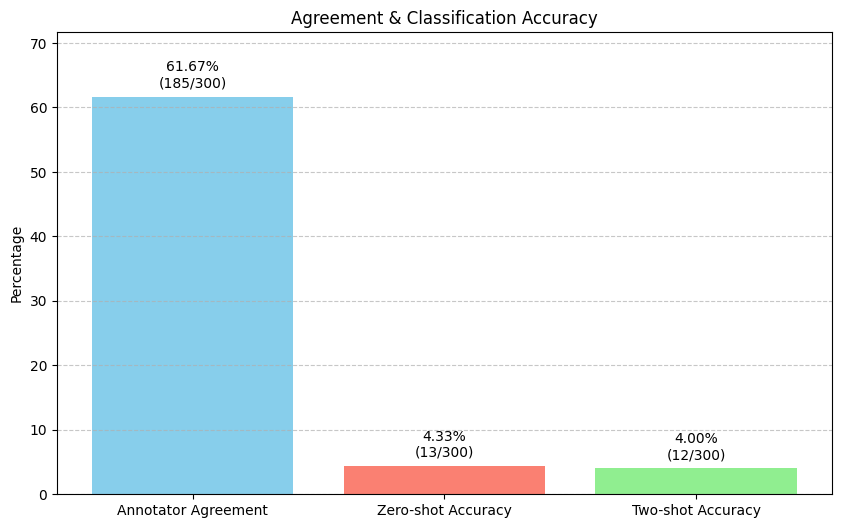

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Annotator Agreement', 'Zero-shot Accuracy', 'Two-shot Accuracy']

# Raw counts
manual_single = 185
manual_soft = 115
zero_shot_correct = 13
zero_shot_total = 300
two_shot_correct = 12
two_shot_total = 300

# Heights of the bars = % values
values = [
    manual_single / (manual_single + manual_soft) * 100,   # % single-label
    zero_shot_correct / zero_shot_total * 100,             # zero-shot accuracy
    two_shot_correct / two_shot_total * 100                # two-shot accuracy
]

# Raw counts for label display
labels = [
    f"{manual_single}/{manual_single + manual_soft}",
    f"{zero_shot_correct}/{zero_shot_total}",
    f"{two_shot_correct}/{two_shot_total}"
]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, values, color=['skyblue', 'salmon', 'lightgreen'])

# Add value labels above bars
for bar, val, raw in zip(bars, values, labels):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f"{val:.2f}%\n({raw})", ha='center', va='bottom', fontsize=10)

# Style
ax.set_ylim(0, max(values) + 10)
ax.set_ylabel("Percentage")
ax.set_title("Agreement & Classification Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


#List of aesthetics

In [ ]:
import pandas as pd

# Load the spreadsheet
file_path = #aesthetics_datataset.csv  # update as needed
df = pd.read_excel(file_path)

# Extract aesthetics
all_aesthetics = set()  # using a set to avoid duplicates

for annotation in df['Final Annotation'].dropna():
    aesthetics = [a.strip() for a in str(annotation).split('/')]
    all_aesthetics.update(aesthetics)

# Sort alphabetically
sorted_aesthetics = sorted(all_aesthetics)

# Print results
print("Unique aesthetics (alphabetical):")
for aesthetic in sorted_aesthetics:
    print("-", aesthetic)

print(f"\nTotal unique aesthetics: {len(sorted_aesthetics)}")


Unique aesthetics (alphabetical):
- 
- 2014 Girly
- 2014 Tumblr
- After Hours
- Angelcore
- Bastardcore
- Bimbocore
- Bloomcore
- Castlecore
- Clean Girl
- Comfy
- Coquette
- Cottagecore
- Cozy
- Dark Academia
- Dazecore
- Deep Fried Meme
- Dethereal
- Doomer
- Dreamcore
- Dreamy
- Ethereal
- Foodie
- Grandpacore
- Grandparentcore
- Hermaphroditus
- Hopecore
- Imaginarium
- Light Academia
- Liminal Space
- Lovecore
- Messy French It Girl
- Naturecore
- Old Money
- Pastels
- Peoplehood
- Phony Bureaucracy
- Pink Parisian
- Politicalwave
- Princesscore
- Queencore
- Red Academia
- Sadpeople
- Sigma
- Slavic Violence Tumblr
- Sleepycore
- Soft Macabre
- Southern Gothic
- Strega
- Teenage Dream
- That Girl
- Traumacore
- Trenchcore
- Waif
- Warmcore
- Weirdcore

Total unique aesthetics: 56


In [ ]:
import pandas as pd
from collections import defaultdict

# Load the spreadsheet
file_path = #yourpath  # update this path
df = pd.read_excel(file_path)

# Dictionary to store aesthetics and their associated titles
aesthetic_to_titles = defaultdict(list)

# Build the mapping
for _, row in df.iterrows():
    title = str(row['Image Name']).strip()
    final_annotation = str(row['Final Annotation'])

    if pd.isna(final_annotation):
        continue

    aesthetics = [a.strip() for a in final_annotation.split('/')]
    for aesthetic in aesthetics:
        aesthetic_to_titles[aesthetic].append(title)

# Sort aesthetics alphabetically
sorted_aesthetics = sorted(aesthetic_to_titles.keys())

# Print results
for aesthetic in sorted_aesthetics:
    print(f"\n🎨 {aesthetic} ({len(aesthetic_to_titles[aesthetic])} images)")
    for title in aesthetic_to_titles[aesthetic]:
        print(" -", title)



🎨  (1 images)
 - 103

🎨 2014 Girly (1 images)
 - 56

🎨 2014 Tumblr (8 images)
 - 54
 - 87
 - 152
 - 154
 - 169
 - 191
 - 233
 - 240

🎨 After Hours (7 images)
 - 118
 - 119
 - 158
 - 174
 - 209
 - 234
 - 251

🎨 Angelcore (25 images)
 - 8
 - 18
 - 23
 - 34
 - 39
 - 47
 - 74
 - 91
 - 107
 - 110
 - 129
 - 144
 - 184
 - 189
 - 191
 - 193
 - 197
 - 202
 - 203
 - 236
 - 245
 - 258
 - 279
 - 281
 - 286

🎨 Bastardcore (3 images)
 - 166
 - 173
 - 236

🎨 Bimbocore (3 images)
 - 2
 - 132
 - 180

🎨 Bloomcore (2 images)
 - 141
 - 170

🎨 Castlecore (7 images)
 - 46
 - 53
 - 84
 - 191
 - 193
 - 250
 - 257

🎨 Clean Girl (9 images)
 - 19
 - 30
 - 40
 - 56
 - 66
 - 180
 - 222
 - 231
 - 233

🎨 Comfy (6 images)
 - 41
 - 50
 - 57
 - 177
 - 213
 - 219

🎨 Coquette (14 images)
 - 42
 - 61
 - 78
 - 114
 - 124
 - 152
 - 161
 - 180
 - 206
 - 213
 - 246
 - 254
 - 284
 - 291

🎨 Cottagecore (20 images)
 - 22
 - 25
 - 26
 - 37
 - 62
 - 75
 - 103
 - 112
 - 116
 - 121
 - 136
 - 160
 - 172
 - 185
 - 208
 - 212
 - 218
 